# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.61MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.0MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Data Statistics


torch.Size([128, 1, 28, 28])
torch.Size([128])


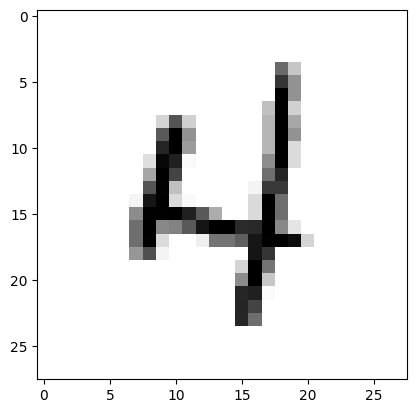

In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


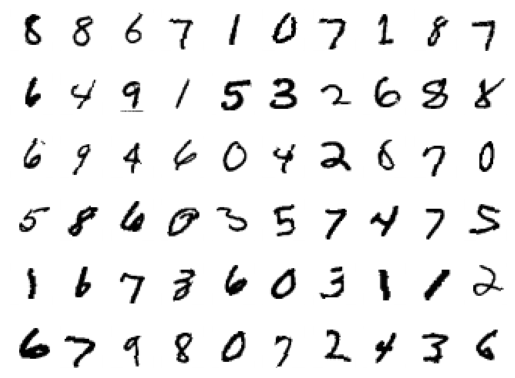

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model 1


In [7]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False)

        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False)

        self.conv5 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False)

        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False)

        self.conv7 = nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)

        self.gap = nn.AvgPool2d(kernel_size=7)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.pool1(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Params

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = MNISTNet().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,608
              ReLU-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 32, 22, 22]           9,216
              ReLU-6           [-1, 32, 22, 22]               0
         MaxPool2d-7           [-1, 32, 11, 11]               0
            Conv2d-8           [-1, 16, 11, 11]             512
              ReLU-9           [-1, 16, 11, 11]               0
           Conv2d-10             [-1, 32, 9, 9]           4,608
             ReLU-11             [-1, 32, 9, 9]               0
           Conv2d-12             [-1, 32, 7, 7]           9,216
             ReLU-13             [-1, 32, 7, 7]               0
           Conv2d-14             [

## Training and Testing

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## Let's Train and test our model

In [11]:
model =  MNISTNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=2.2980003356933594 Batch_id=468 Accuracy=10.32: 100%|██████████| 469/469 [00:23<00:00, 19.58it/s]



Test set: Average loss: 2.2984, Accuracy: 1534/10000 (15.34%)

EPOCH: 1


Loss=0.27774515748023987 Batch_id=468 Accuracy=51.30: 100%|██████████| 469/469 [00:25<00:00, 18.73it/s]



Test set: Average loss: 0.4378, Accuracy: 8636/10000 (86.36%)

EPOCH: 2


Loss=0.13763831555843353 Batch_id=468 Accuracy=90.70: 100%|██████████| 469/469 [00:20<00:00, 22.43it/s]



Test set: Average loss: 0.1685, Accuracy: 9482/10000 (94.82%)

EPOCH: 3


Loss=0.11172457784414291 Batch_id=468 Accuracy=94.21: 100%|██████████| 469/469 [00:22<00:00, 20.56it/s]



Test set: Average loss: 0.1388, Accuracy: 9556/10000 (95.56%)

EPOCH: 4


Loss=0.15018537640571594 Batch_id=468 Accuracy=95.12: 100%|██████████| 469/469 [00:20<00:00, 22.47it/s]



Test set: Average loss: 0.1136, Accuracy: 9643/10000 (96.43%)

EPOCH: 5


Loss=0.06488358229398727 Batch_id=468 Accuracy=95.84: 100%|██████████| 469/469 [00:20<00:00, 22.46it/s]



Test set: Average loss: 0.1040, Accuracy: 9689/10000 (96.89%)

EPOCH: 6


Loss=0.04544781520962715 Batch_id=468 Accuracy=96.13: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]



Test set: Average loss: 0.1072, Accuracy: 9661/10000 (96.61%)

EPOCH: 7


Loss=0.2006305456161499 Batch_id=468 Accuracy=96.61: 100%|██████████| 469/469 [00:20<00:00, 22.38it/s]



Test set: Average loss: 0.0802, Accuracy: 9754/10000 (97.54%)

EPOCH: 8


Loss=0.18469245731830597 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:24<00:00, 19.47it/s]



Test set: Average loss: 0.0679, Accuracy: 9789/10000 (97.89%)

EPOCH: 9


Loss=0.09912880510091782 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:21<00:00, 21.58it/s]



Test set: Average loss: 0.0856, Accuracy: 9726/10000 (97.26%)

EPOCH: 10


Loss=0.24857766926288605 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]



Test set: Average loss: 0.0758, Accuracy: 9759/10000 (97.59%)

EPOCH: 11


Loss=0.09959596395492554 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:22<00:00, 20.85it/s]



Test set: Average loss: 0.0980, Accuracy: 9705/10000 (97.05%)

EPOCH: 12


Loss=0.08592363446950912 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:20<00:00, 22.87it/s]



Test set: Average loss: 0.0677, Accuracy: 9772/10000 (97.72%)

EPOCH: 13


Loss=0.06925461441278458 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:21<00:00, 21.44it/s]



Test set: Average loss: 0.0701, Accuracy: 9774/10000 (97.74%)

EPOCH: 14


Loss=0.01760009489953518 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:22<00:00, 21.23it/s]



Test set: Average loss: 0.0520, Accuracy: 9847/10000 (98.47%)



In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_training_curve(train_losses, train_acc, test_losses, test_acc):
    t = [t_items.item() for t_items in train_losses]
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(t)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc[4000:])
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")

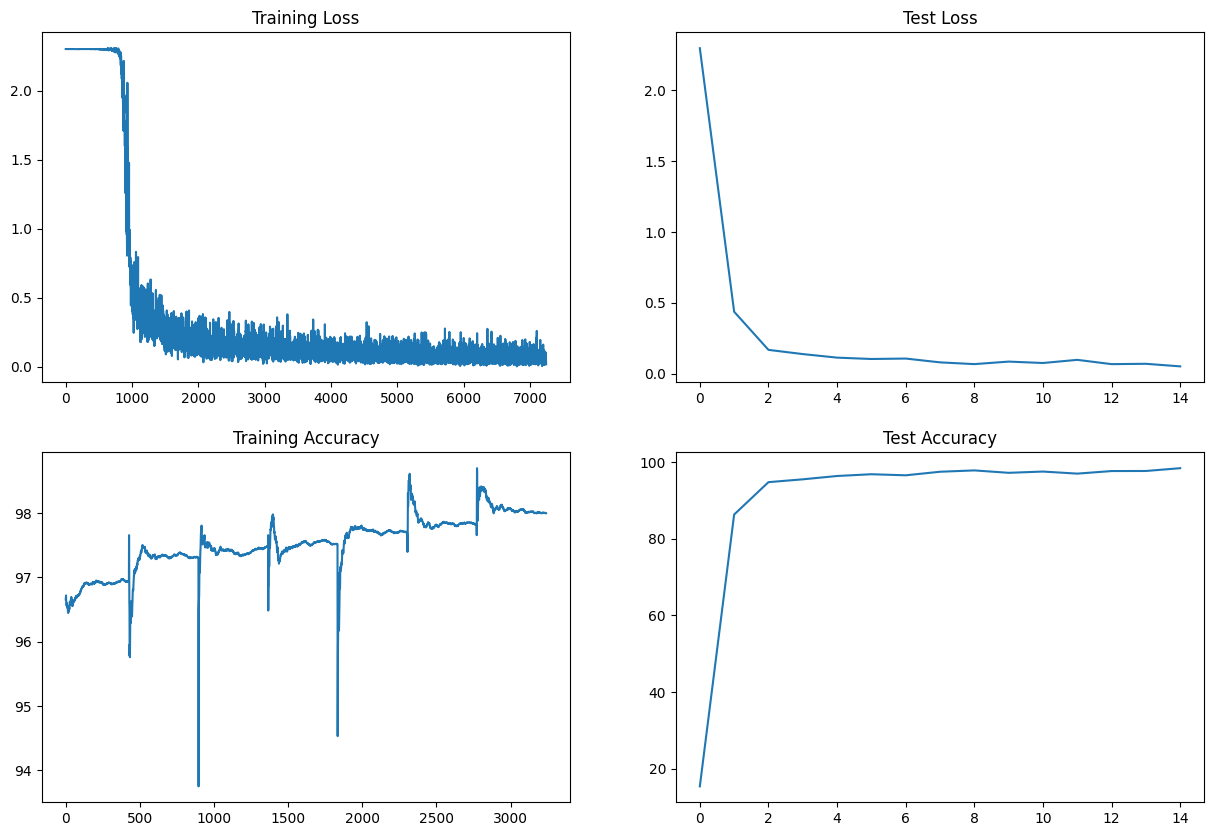

In [13]:
plot_training_curve(train_losses, train_acc, test_losses, test_acc)

## Target, Results and Analysis

### Target
*   Get the set-up right
*   Set Transforms
*   Set Data Loader
*   Set Basic Working Code
*   Set Basic Training  & Test Loop
*   Achieving > 99.4 % accuracy in less than 15 epochs

  
### Result

Model Parameters: 28,624  
Best Train Accuracy: 98.00  
Best Test Accuracy: 98.47
  
### Analysis
- Though the network has more than 26000 parameters, it could not achieve more than 99% accuracy in 15 epochs. So model is not converging quickly.
- Model is slightly under-fitting (or can be considered neither under-fitting nor over-fitting)
- Only Random rotation is added as Augmentation.
- In the architecture GAP size is 7 x 7. That might the reason of low accuracy as well.
